In [5]:
import os
from os import listdir
from os.path import isfile, join
import random
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torchvision import transforms, models
from PIL import Image
import cv2

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    print("CUDA Available")

CUDA Available


In [6]:
# PATH = "./EyesDataset/"
ONES_PATH = "./Open/"
ZEROS_PATH = "./Closed/"
TEST_ONES_PATH = "./OpenTest/"
TEST_ZEROS_PATH = "./ClosedTest/"

TEST_PATH = "./EyesDatasetTest/"
MODEL_PATH = "./efnet_b3_pt.pth"

IMG_SIZE = (24, 24)
NEW_SIZE = (224, 224)

In [252]:
TO_TENSOR = transforms.ToTensor()
NORMALIZE = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
IMAGE_TRANSFORMS = transforms.Compose([        
        transforms.Resize(NEW_SIZE),
        transforms.RandomRotation(20),        
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAffine(degrees=20, translate=(0, 0.1), scale=(0.8, 1.25)),
        NORMALIZE,
    ])
TEST_TRANSFORMS = transforms.Compose([
        transforms.Resize(NEW_SIZE),
        NORMALIZE,
    ])

In [10]:
def get_image_names_from_dir(path, full=False):
    ''' Returns list of file names and full paths in directory, 
        if full==False, then list of names only.
    '''
    if full:
        return [join(path, f) for f in listdir(path) if (isfile(join(path, f)) and f[-4:] == '.jpg')]
    else:
        return [f for f in listdir(path) if isfile(join(path, f))]

In [147]:
def show_images(image_list, amount=None, columns=16, scale=2, randomize=False, mark=True, labels=None):
    ''' Displays amount or all of scaled images in columns from image_list
        randomized if needed,
        marked with filename,
        labeleb by mark color        
    '''
    img_sum = None
    img_row = None
    if not amount or amount > len(image_list):
        amount = len(image_list)
    image_list = image_list.copy()
    if randomize:
        random.shuffle(image_list)
    for i, img_name in enumerate(image_list):
        if i == amount:
            break
        if img_row is not None and i % columns == 0:
            if img_sum is None:
                img_sum = img_row
            else:
                img_sum = np.concatenate((img_sum, img_row), axis=0)
            img_row = None
        img = cv2.imread(img_name)        
        img = cv2.resize(img, tuple(map(lambda x: scale * x, IMG_SIZE)))   
        short_name = img_name[-8:]
        if labels is not None and short_name in labels:
            label = labels[short_name]
            text_color = (int(100*(1 - label)), 0, int(100*label))
        else:
            text_color = (50,50,50)        
        if mark:
            cv2.putText(
                img=img,
                text=img_name[-8:-4], 
                org=(2, IMG_SIZE[1] * scale - 2),  # bottomLeftCornerOfText
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=0.25,
                color=text_color,
                thickness=1,
                lineType=2,
            )        
        if img_row is None:
            img_row = img
        else:
            img_row = np.concatenate((img_row, img), axis=1)
        
    if img_row is not None:
        if img_sum is None:
            img_sum = img_row
        else:
            while img_row.shape[1] // columns !=  IMG_SIZE[1] * scale:
                img_row = np.concatenate(
                    (img_row, np.ones(list(map(lambda x: scale * x, IMG_SIZE))+[3], dtype=np.uint8) * 255), 
                    axis=1
                )
            img_sum = np.concatenate((img_sum, img_row), axis=0)
        img_row = None
    if img_sum is not None:
        display(Image.fromarray(img_sum))    


In [130]:
ones_list = get_image_names_from_dir(ONES_PATH, full=True)
zeros_list = get_image_names_from_dir(ZEROS_PATH, full=True)

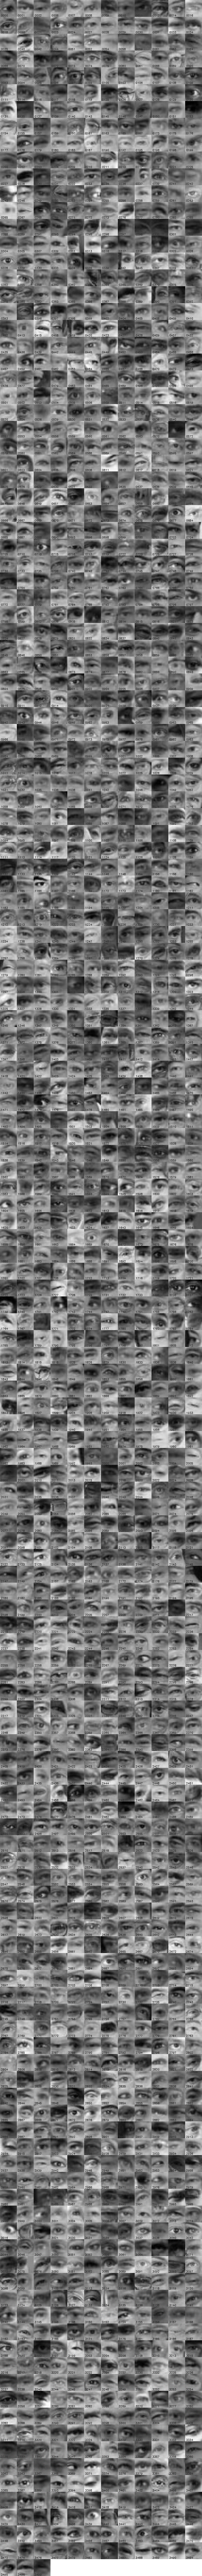

In [145]:
show_images(ones_list, columns = 12, scale=2, randomize=False, mark=True)

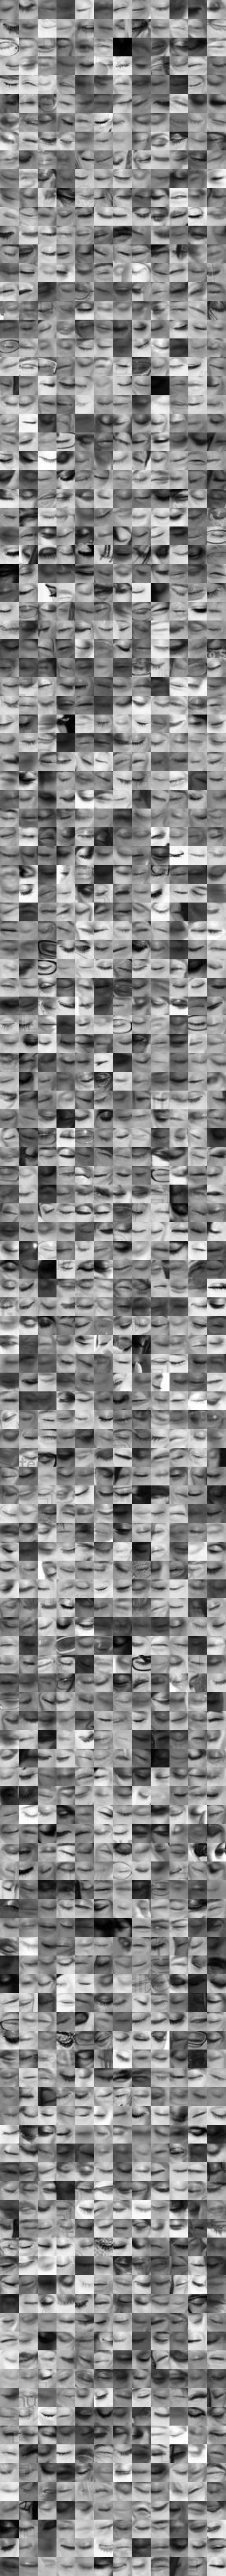

In [15]:
show_images(zeros_list, columns=12, scale=2, randomize=False, mark=False)

In [253]:
class EyesDataset(torch.utils.data.Dataset):
    ''' Create dataset to format data, to use in standard Dataloader    
    '''
    def __init__(self, 
                 ones_path=ONES_PATH,
                 zeros_path=ZEROS_PATH,                 
                 train=True
                ):
        super().__init__()
        self.ones_path = ones_path
        self.zeros_path = zeros_path 
        self.train = train
        self.files = []
        files = get_image_names_from_dir(self.ones_path, full=True)        
        self.files += [pair for pair in zip(files, [np.array([0, 1])] * len(files))]
        files = get_image_names_from_dir(self.zeros_path, full=True)
        self.files += [pair for pair in zip(files, [np.array([1, 0])] * len(files))]
        self.ids = list(range(len(self.files))) # indices of filenames
        random.seed(0)
        random.shuffle(self.ids)
        self._len = len(self.ids)
        print("Dataset length: ", self._len)
        
    def __len__(self):
        return self._len
    
    def tfs(self, image, rnd=True):
        image = TO_TENSOR(image)
        if rnd:
            image = IMAGE_TRANSFORMS(image)
        else:
            image = TEST_TRANSFORMS(image)
        return image
    
    def getname(self, i):
        if self.train:
            return None
        else:
            return self.files[i][0]
    
    def __getitem__(self, i):
        if self.train:
            img_name, target = random.choice(self.files)
        else:
            img_name, target = self.files[i]
        image = cv2.imread(img_name)
        image = self.tfs(image, rnd=self.train)

        return image, target

In [325]:
trainset = EyesDataset(ones_path=ONES_PATH, zeros_path=ZEROS_PATH)
valset = EyesDataset(ones_path=TEST_ONES_PATH, zeros_path=TEST_ZEROS_PATH, train=False)

Dataset length:  3500
Dataset length:  500


In [18]:
def make_optimizer(model, lr=1e-3):
    return torch.optim.Adam(model.parameters(), lr=lr)

In [19]:
# model = models.efficientnet_b3(pretrained=True)

In [27]:
# model.classifier = nn.Sequential(
#     nn.Dropout(p=0.3, inplace=True),
#     nn.Linear(in_features=1536, out_features=2, bias=True),
# )

In [29]:
# model = models.efficientnet_b3(pretrained=False, num_classes=2)
x = torch.randn(2, 3, *NEW_SIZE)
model(x)[0].shape

torch.Size([2])

In [31]:
loss = nn.BCEWithLogitsLoss()
if USE_CUDA:
    model.cuda()
    loss.cuda()
optimizer = make_optimizer(model)

In [33]:
# model.load_state_dict(torch.load(MODEL_PATH)['model_state_dict'])
# optimizer.load_state_dict(torch.load(MODEL_PATH)['optimizer_state_dict'])

In [36]:
def train_loop(model, optimizer, loss, train_loader, 
               n_iter, lr_scheduler=None, plot=None, 
               plot_kwargs={}, use_cuda=False, plot_steps=10):
    ''' Train loop
    '''
    model.train()
    losses = []
    for i, (items, targets) in enumerate(train_loader):
        if i == n_iter:
            break
        if use_cuda:
            items = items.cuda()
            targets = targets.cuda()

        out = model(items)
        loss_value = loss(out, targets.float())
        
        optimizer.zero_grad()        
        loss_value.backward()
        optimizer.step()
        
        if lr_scheduler is not None:
            lr_scheduler.step()

        losses.append(loss_value.item())
        if i % 10 == 0:
            print("Step {} / {}, loss: {:.4f}, learning rate: {:.5f}\r".format(i, n_iter, loss_value.item(), optimizer.param_groups[0]["lr"]), end="")
    print(" " * 50 + "\r", end="")
    print("Train loss: {:.4f}, learning rate: {:.5f}".format(np.mean(losses[-plot_steps:]), optimizer.param_groups[0]["lr"]))
    return np.mean(losses)

In [37]:
def eval_model(model, loss, test_loader, batch_size,
               use_cuda=False,
               num_workers=1):
    ''' Evaluation cycle
    '''
    model.eval()
#     clear_output()
    kwargs = {}
    losses = []
    with torch.no_grad():
        for items, targets in test_loader:
            if use_cuda:
                items = items.cuda()
                targets = targets.cuda()

        out = model(items)
        loss_value = loss(out, targets.float())
        
        losses.append(loss_value.item())
    test_loss = np.mean(losses)
    print(f"Test loss:{test_loss:.4f}", )
    return test_loss

In [327]:
# # this used for cache empty, to choose right batch_size
# torch.cuda.empty_cache()
# if USE_CUDA:
#     model.cuda()
#     loss.cuda()
# optimizer = make_optimizer(model)

best_eval = 100
epoch = 0
batch_size = 8
n_iters = 2000
eval_steps = 1000

loss_storage = []
train_loss_storage = []    

In [ ]:
train_loader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_size,
    shuffle=True, 
    num_workers=0
    )

test_loader = torch.utils.data.DataLoader(
    valset, 
    batch_size=batch_size,
    num_workers=0
    )

In [467]:
# for g in optimizer.param_groups:
#     g['lr'] = 0.00003

In [329]:
%%time
num_epochs = 3
while epoch < num_epochs:
    i = 0
    while i < n_iters:    
        train_steps = min(eval_steps, n_iters - i)
        train_loss = train_loop(model, optimizer, loss, train_loader, train_steps,
                   lr_scheduler=None,
                   use_cuda=USE_CUDA)
        i += train_steps
    eval_loss = eval_model(model, loss, test_loader, batch_size,
                           use_cuda=USE_CUDA)
    if eval_loss < best_eval:
        best_eval = eval_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': eval_loss,
            }, MODEL_PATH)
        print('Saving...')
    print(f'Epoch: {epoch+1}')
#     loss_storage.append(eval_loss)
    train_loss_storage.append(train_loss)
    epoch = epoch + 1

Train loss: 0.0146329, learning rate: 0.00100     10
Train loss: 0.0673110, learning rate: 0.00100     10
Test loss:0.0096
Saving...
Epoch: 2
Wall time: 5min 34s


In [165]:
# model.load_state_dict(torch.load(MODEL_PATH)['model_state_dict'])
# optimizer.load_state_dict(torch.load(MODEL_PATH)['optimizer_state_dict'])

In [484]:
# torch.save({
#     'epoch': epoch,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
# #     'loss': eval_loss,
#     }, MODEL_PATH)

In [351]:
# torch.save(model, "./enet_b3_0021.pth")

In [402]:
def get_preds(model, valset):
    ''' Get predictions from dataset
        returns predictions, names of images, 
        real categories list (for ROC AUC and EER computation)
        and dict or real categories with image names as keys (for visualization)
    '''
    preds = []
    names = []
    real_cats = []
    model.eval()
    for i in range(len(valset)):
        image, cat = valset[i]
        
        names.append(valset.getname(i))    
        cat = cat[1]
        real_cats.append(cat)
        image = image.unsqueeze(0)

        if USE_CUDA:
            model.cuda()
            image = image.cuda() 
        with torch.no_grad():
            pred = model(image)
            pred = nn.Sigmoid()(pred)
            pred = torch.softmax(pred, dim=1)
            preds.append(pred.detach().cpu().squeeze().numpy())
    real_cats_dict = dict(zip([name[-8:] for name in names], real_cats))
    print(f"Length of predictions: {len(preds)}")
    return preds, names, real_cats, real_cats_dict   

In [352]:
valset2 = EyesDataset(ones_path=ONES_PATH, zeros_path=ZEROS_PATH, train=False)
preds, names, real_cats, real_cats_dict = get_preds(model, valset2)

Dataset length:  3500


In [403]:
preds, names, real_cats, real_cats_dict = get_preds(model, valset)

Length of predictions: 500


In [373]:
# getting logits for 1 class here
logits = list(map(lambda x: x[1], preds))
logits[:3]

[0.729767, 0.7310502, 0.7209344]

In [418]:
# for eer
fpr, tpr, threshold = roc_curve(real_cats, logits, pos_label=1)
fnr = 1 - tpr
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
print(f"EER threshold: {eer_threshold:.4f}")
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print(f"EER value    : {EER:.4f}")
labels = list(map(lambda x: 1 if x[1] >= eer_threshold else 0, preds))

EER threshold: 0.2877
EER value    : 0.0211


In [409]:
# tpr

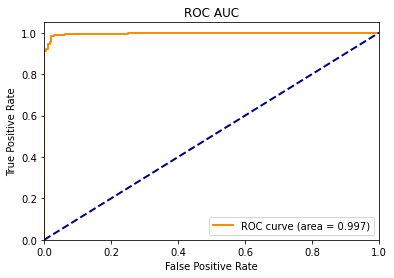

In [419]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.3f)" % auc(fpr, tpr),
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC")
plt.legend(loc="lower right")
plt.show()

In [345]:
# saving images to folders here, for easy evaluation 
test_images = names
for img_name, label in zip(test_images, labels):
    label_path = os.path.join(str(label))
    if not os.path.exists(label_path):
        os.makedirs(label_path)
    save_path = os.path.join(label_path, img_name[-10:])
    img = Image.open(img_name)
    if False:
        img = img.resize((48, 48), Image.ANTIALIAS)
    with open(save_path, 'w') as f:            
        img.save(f)

In [347]:
test_images_ones = get_image_names_from_dir("./1/", full=True)
test_images_zeros = get_image_names_from_dir("./0/", full=True)

In [348]:
# real_cats_dict

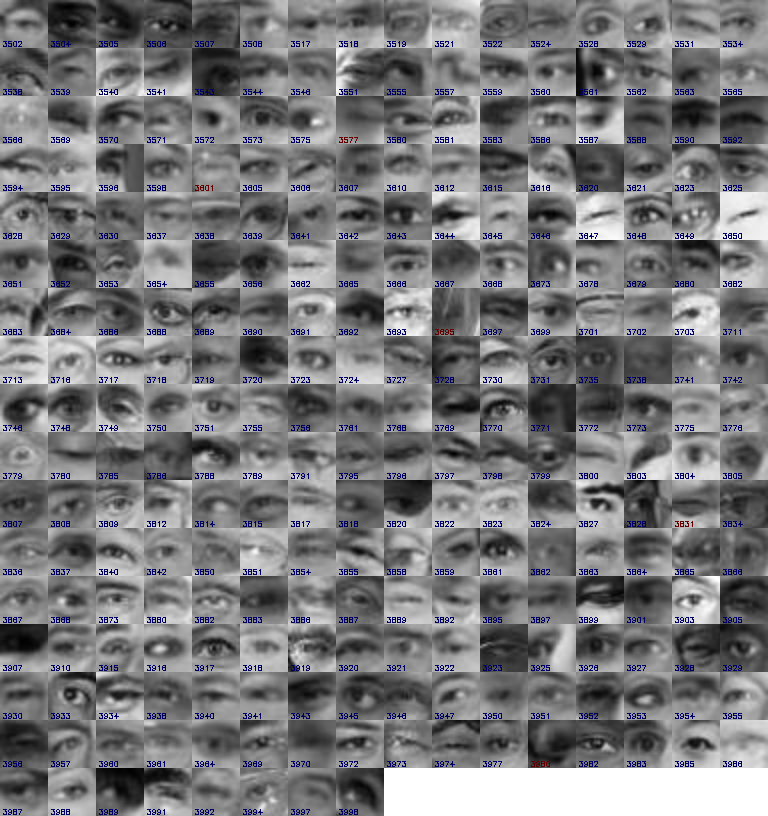

In [349]:
show_images(test_images_ones, randomize=False, mark=True, labels=real_cats_dict)

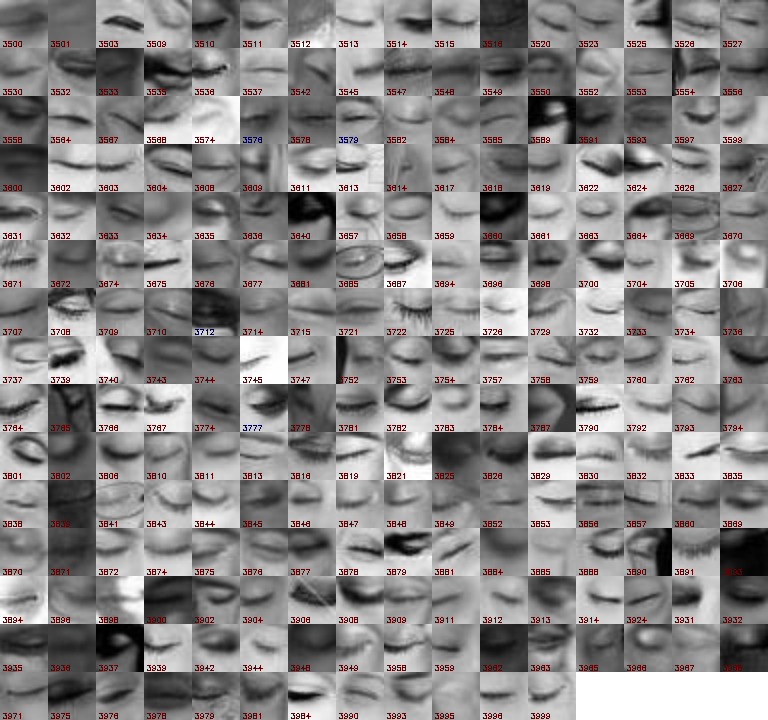

In [350]:
show_images(test_images_zeros, randomize=False, mark=True, labels=real_cats_dict)

In [360]:
# class OpenEyesClassificator:
#     def __init__(self, model_path=MODEL_PATH, use_cuda=USE_CUDA):
#         self.model = torch.load(model_path)
#         self.use_cuda = use_cuda
#         self.transforms = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Resize((224, 224)),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         ])
#         self.sigmoid = torch.nn.Sigmoid()

#     def predict(self, inpIm):
#         self.model.eval()
#         image = cv2.imread(inpIm)
#         image = self.transforms(image)
#         image = image.unsqueeze(0)

#         if self.use_cuda:
#             self.model.cuda()
#             image = image.cuda()
#         with torch.no_grad():
#             pred = self.model(image)
#             pred = self.sigmoid(pred)
#             is_open_score = torch.softmax(pred, dim=1).detach().cpu().squeeze().numpy()[1]
#         return is_open_score

In [361]:
# oc = OpenEyesClassificator(model_path="./enet_b3_0021.pth")

In [396]:
# test_images = get_image_names_from_dir("./EyesDatasetTest/", full=True)

In [420]:
# %%time
# for name in test_images:
#     pred = oc.predict(name)
# #     if pred < 0.31:
# #         print(name, pred)

Wall time: 11.8 s
